# ラベル分布に関するEDA

- ラベルの分布がSPaRCNetとどの程度似ているのかを確認する

In [1]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata.head()

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,seizure_vote_per_eeg,lpd_vote_per_eeg,gpd_vote_per_eeg,lrda_vote_per_eeg,grda_vote_per_eeg,other_vote_per_eeg,label_count_per_eeg,total_votes_per_eeg,population,population_per_eeg,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,seizure_prob_per_eeg,lpd_prob_per_eeg,gpd_prob_per_eeg,lrda_prob_per_eeg,grda_prob_per_eeg,other_prob_per_eeg,num_unique_vote_combinations_per_eeg,duration_sec,duration_min,num_labels_per_eeg,num_unique_vote_combinations_per_label,num_labels_per_duration_sec,num_unique_vote_combinations_per_duration_sec,min_eeg_label_offset_sec,max_eeg_label_offset_sec,log_num_labels_per_eeg,diversity,diversity_weight,population_weight,population_per_eeg_weight,weight,weight_per_eeg
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,0.0,0.0,0.0,0.0,9,3.0,0.107143,0.107143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,90.0,1.5,9,0.111111,0.1,0.011111,0.0,40.0,2.197225,0.111111,1.0,0.107143,0.107143,0.107143,0.107143


SPaRCNetのデータの分布

* low-quality
    * Dataset 1: 111,095 EEG Segments, 1,950 patients
    * Dataset 2
* high-quality
    * Dataset 3 (train): 36,242 EEG Segments, 761 patients
    * Dataset 4 (test): 35,740 EEG Segments, 761 patients

In [35]:
very_low_quality = metadata.filter(pl.col("total_votes").lt(3))
low_quality = metadata.filter(
    pl.col("total_votes").ge(3).and_(pl.col("total_votes").lt(10))
)
high_quality = metadata.filter(pl.col("total_votes").ge(10))

In [36]:
very_low_quality.shape[0], low_quality.shape[0], high_quality.shape[0]

(6676, 60178, 39946)

In [13]:
low_quality["patient_id"].n_unique(), high_quality["patient_id"].n_unique()

(1583, 1063)

In [19]:
low_quality["expert_consensus"].value_counts()

expert_consensus,count
str,u32
"""LPD""",5901
"""Seizure""",19966
"""GRDA""",12957
"""GPD""",5548
"""Other""",5658
"""LRDA""",10148


In [22]:
LABELS

['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

In [21]:
high_quality["expert_consensus"].value_counts()

expert_consensus,count
str,u32
"""GPD""",10077
"""LRDA""",6230
"""Other""",10220
"""GRDA""",5383
"""LPD""",7440
"""Seizure""",596


In [24]:
high_quality.filter(
    pl.col("expert_consensus").is_in(["Seizure", "LPD", "GPD", "LRDA", "GRDA"])
).get_column("patient_id").n_unique()

585

In [30]:
patient_ids = set(high_quality.filter(pl.col("other_prob").eq(1)).get_column("patient_id").unique().to_list())
len(patient_ids)

326

In [38]:
patient_ids_lq = low_quality.get_column("patient_id").unique().to_list()
len(patient_ids_lq)

1583

In [37]:
patient_ids_vlq = very_low_quality.get_column("patient_id").unique().to_list()
len(patient_ids_vlq)

770

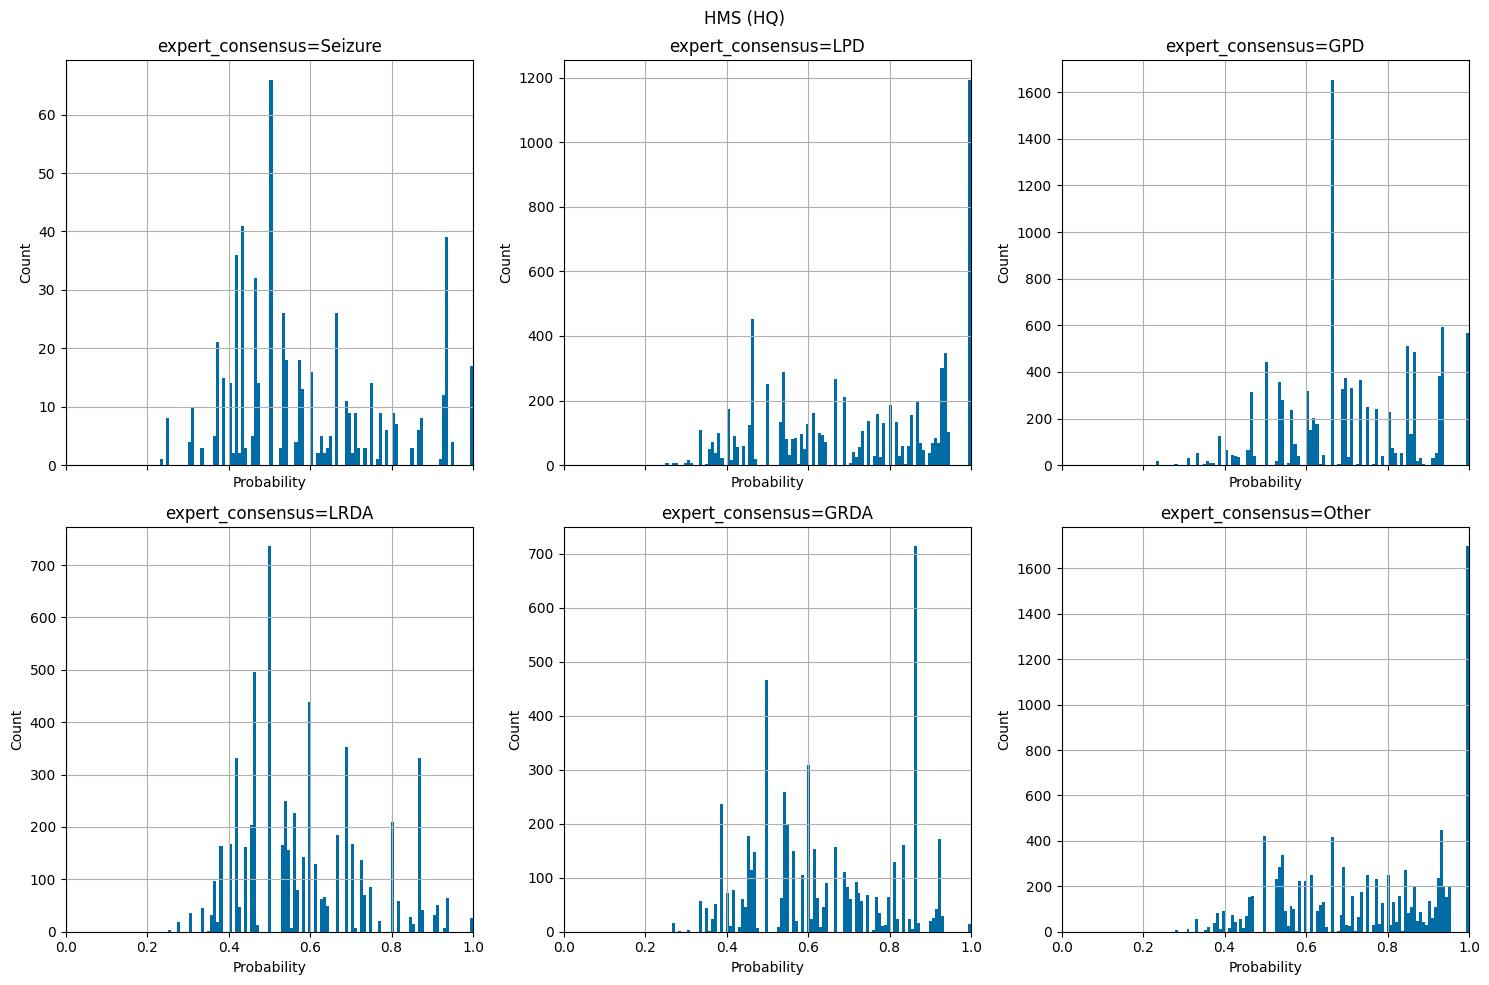

In [76]:
_, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
axes = axes.flatten()
seizure_types = ["Seizure", "LPD", "GPD", "LRDA", "GRDA", "Other"]
for cls, ax in zip(seizure_types, axes):
    df = high_quality.filter(pl.col("expert_consensus").eq(cls))
    df[f"{cls.lower()}_prob"].to_pandas().hist(bins=100, ax=ax)
    ax.set(title=f"expert_consensus={cls}", xlabel="Probability", ylabel="Count", xlim=(0, 1))
plt.suptitle("HMS (HQ)")
plt.tight_layout()
plt.show()

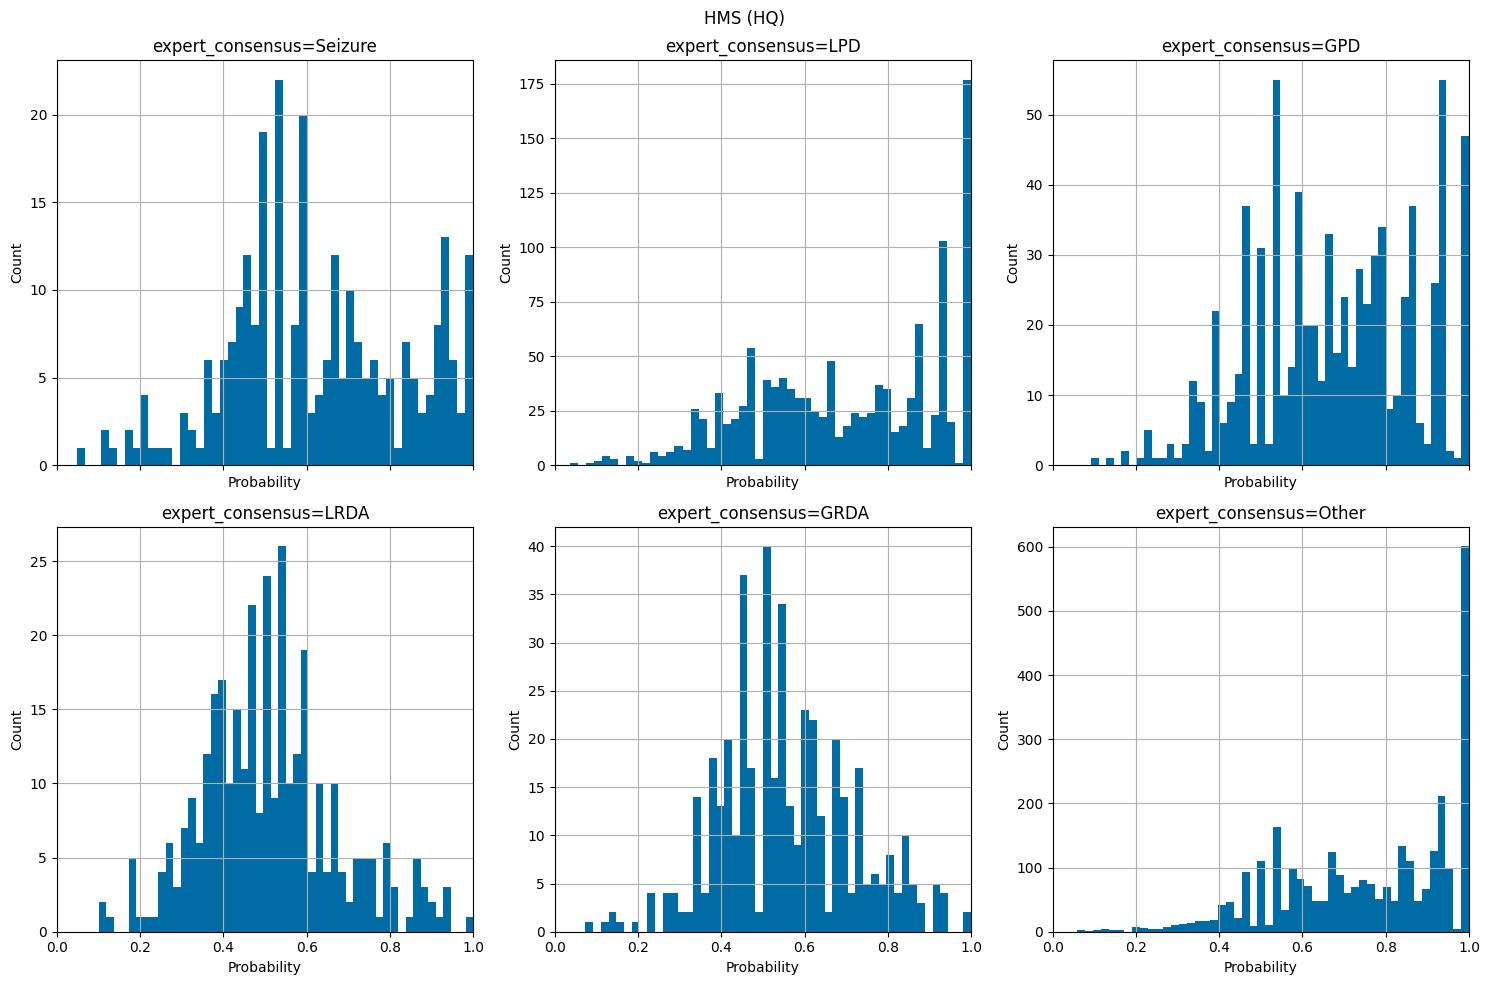

In [84]:
_, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
axes = axes.flatten()
seizure_types = ["Seizure", "LPD", "GPD", "LRDA", "GRDA", "Other"]
for cls, ax in zip(seizure_types, axes):
    df = high_quality.filter(pl.col("expert_consensus").eq(cls))
    df = df.group_by("eeg_id").agg(
        pl.col(f"{cls.lower()}_prob_per_eeg").first().alias(f"{cls.lower()}_prob")
    )
    df[f"{cls.lower()}_prob"].to_pandas().hist(bins=50, ax=ax)
    ax.set(
        title=f"expert_consensus={cls}",
        xlabel="Probability",
        ylabel="Count",
        xlim=(0, 1),
    )
plt.suptitle("HMS (HQ)")
plt.tight_layout()
plt.show()